# Corrélations non linéaires

Les corrélations indiquent si deux variables sont linéairement équivalentes. Comment étendre cette notion à des variables liées mais pas de façon linéaire.

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [ ]:
%matplotlib inline

## Un exemple

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
Y = iris.target
import pandas
df = pandas.DataFrame(X)
df.columns = ["X1", "X2", "X3", "X4"]
df.head()

,X1,X2,X3,X4
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


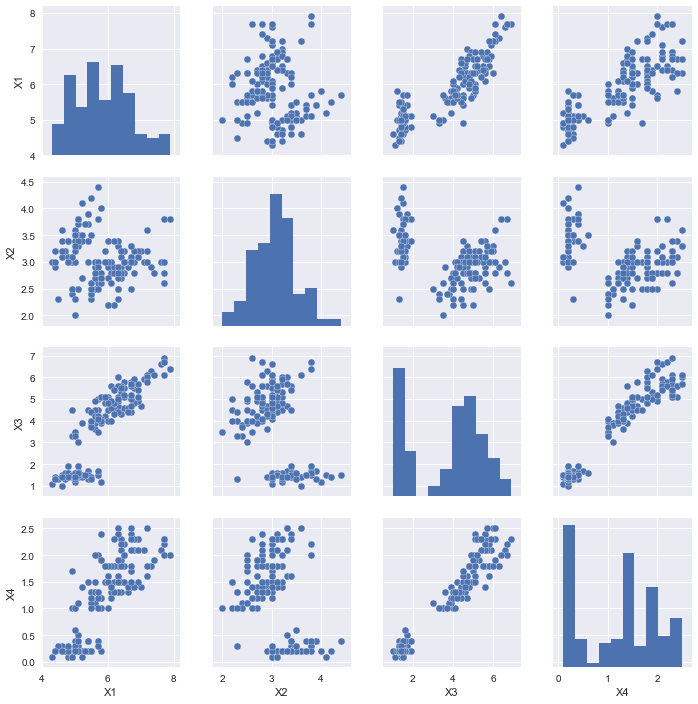

In [ ]:
import seaborn as sns
sns.set()
sns.pairplot(df)

Et les corrélations :

In [ ]:
df.corr()

,X1,X2,X3,X4
X1,1.000000,-0.109369,0.871754,0.817954
X2,-0.109369,1.000000,-0.420516,-0.356544
X3,0.871754,-0.420516,1.000000,0.962757
X4,0.817954,-0.356544,0.962757,1.000000


## Un peu de théorie

Le coefficient de [corrélation](https://fr.wikipedia.org/wiki/Corr%C3%A9lation_(statistiques)) de Pearson est calculé comme suit :

$$cor(X_i, X_j) = \frac{cov(X_i, Y_i)}{\sigma(X_i)\sigma(X_j)}$$

Lorsque les variables sont centrées $\mathbb{E}X_i=\mathbb{E}X_j=0$, cette formule devient :

$$cor(X_i, X_j) = \frac{\mathbb{E}(X_i X_j)}{\sqrt{\mathbb{E}X_i^2 \mathbb{E}X_j^2}}$$

Lorsque les variables sont réduites $\mathbb{E}X_i^2=\mathbb{E}X_j^2=1$, cette formule devient $cor(X_i, X_j) = \mathbb{E}(X_i X_j)$. Admettons maintenant que l'on cherche à trouvé le coefficient $\alpha_{ij}$ qui minimise la variance du bruit $\epsilon_{ij}$ :

$$X_j = \alpha_{ij}X_i + \epsilon_{ij}$$

Le coefficient $\alpha_{ij}$ est le résultat d'une régression linéaire qui minimise $\mathbb{E}(X_j - \alpha_{ij}X_i)^2$. Si les variables $X_i$, $X_j$ sont centrées et réduites : $\alpha_{ij}^* = \mathbb{E}(X_i X_j) = cor(X_i, X_j)$. On étend cette définition dans le cas d'une fonction paramétrable $f$ : $f(\omega, X) \rightarrow \mathbb{R}$ et d'une régression non linéaire. On suppose que les paramètres $\omega^*$ minimise la quantité $\min_\omega (X_j  - f(\omega, X_i))^2$. On écrit alors $X_j = \alpha_{ij} \frac{f(\omega^*, X_i)}{\alpha_{ij}} + \epsilon_{ij}$ et on choisit $\alpha_{ij}$ de telle sorte que $\mathbb{E}\left(\frac{f(\omega^*, X_i)^2}{\alpha_{ij}^2}\right) = 1$. On définit la corrélation non linéaire au sens de $f$ : 

$$cor^f(X_i, X_j) = \sqrt{ \mathbb{E} (f(\omega, X_i)^2 )}$$

On vérifie que ce coefficient est compris entre [0, 1]. Cela signifie que cette définition interdit les corrélations négatives.

## Vérifications

Tout d'abord le cas linéaire :

In [ ]:
from sklearn.preprocessing import scale
import numpy

def correlation_etendue(df, model, **params):
    cor = df.corr()
    df = scale(df)    
    for i in range(cor.shape[0]):
        xi = df[:, i:i+1]
        for j in range(cor.shape[1]):
            mod = model(**params)
            xj = df[:, j]
            mod.fit(xi, xj)
            v = mod.predict(xi)
            c = numpy.std(v)
            cor.iloc[i,j] = c
    return cor

from sklearn.linear_model import LinearRegression
cor = correlation_etendue(df, LinearRegression, fit_intercept=False)
cor

,X1,X2,X3,X4
X1,1.000000,0.109369,0.871754,0.817954
X2,0.109369,1.000000,0.420516,0.356544
X3,0.871754,0.420516,1.000000,0.962757
X4,0.817954,0.356544,0.962757,1.000000


Et le cas non linéaire :

In [ ]:
from sklearn.tree import DecisionTreeRegressor
cor = correlation_etendue(df, DecisionTreeRegressor)
cor

,X1,X2,X3,X4
X1,1.000000,0.552078,0.915954,0.879381
X2,0.408612,1.000000,0.585301,0.532106
X3,0.936764,0.784066,1.000000,0.978266
X4,0.846162,0.761086,0.979966,1.000000


In [ ]:
from sklearn.ensemble import RandomForestRegressor
cor = correlation_etendue(df, RandomForestRegressor)
cor

,X1,X2,X3,X4
X1,0.995727,0.599871,0.922425,0.899997
X2,0.415061,0.993451,0.599136,0.523404
X3,0.940305,0.760896,0.999142,0.981646
X4,0.826897,0.730773,0.977941,0.999138


## Overfitting

Ces chiffres sont beaucoup trop optimistes. Les modèles de machine learning peuvent tout à fait faire de l'overfitting. Il faut améliorer la fonction en divisant en apprentissage et test plusieurs fois. Il faut également tenir compte de l'erreur de prédiction. On rappelle que : 

$$X_j = \alpha_{ij} \frac{f(\omega^*, X_i)}{\alpha_{ij}} + \epsilon_{ij} = cor^f(X_i, X_j) \frac{f(\omega^*, X_i)}{\sqrt{ \mathbb{E} (f(\omega, X_i)^2 )}} + \epsilon_{ij}$$

Or $\mathbb{E}(X_j)^2=1$ et on suppose que les bruits ne sont pas corrélées linéairement aux $f(\omega^*, X_i)$. On en déduit que $cor^f(X_i, X_j) = \sqrt{ 1 - \mathbb{E}\epsilon_{ij}^2}$.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy

def correlation_cross_val(df, model, draws=5, **params):
    cor = df.corr()
    df = scale(df)    
    for i in range(cor.shape[0]):
        xi = df[:, i:i+1]
        for j in range(cor.shape[1]):
            xj = df[:, j]
            mem = []
            for k in range(0, draws):
                xi_train, xi_test, xj_train, xj_test = train_test_split(xi, xj, train_size=0.5)
                mod = model(**params)            
                mod.fit(xi_train, xj_train)
                v = mod.predict(xi_test)
                c = (1 - numpy.var(v - xj_test))
                mem.append(max(c, 0) **0.5)
            cor.iloc[i,j] = sum(mem) / len(mem)
    return cor

cor = correlation_cross_val(df, LinearRegression, fit_intercept=False, draws=20)
cor

,X1,X2,X3,X4
X1,1.000000,0.202278,0.876214,0.817330
X2,0.136784,1.000000,0.406487,0.305332
X3,0.871076,0.405804,1.000000,0.960450
X4,0.818503,0.308600,0.962524,1.000000


In [ ]:
cor = correlation_cross_val(df, DecisionTreeRegressor)
cor

,X1,X2,X3,X4
X1,0.998349,0.047298,0.854251,0.770892
X2,0.017942,0.995071,0.184005,0.153760
X3,0.852894,0.338881,0.999112,0.948880
X4,0.749457,0.537604,0.966215,0.999500


In [ ]:
cor = correlation_cross_val(df, RandomForestRegressor)
cor

,X1,X2,X3,X4
X1,0.998646,0.054441,0.856542,0.791687
X2,0.000000,0.997062,0.301525,0.169732
X3,0.889363,0.501166,0.999270,0.957880
X4,0.784743,0.686995,0.967208,0.999071


Les résultats sont assez fluctuants lorsque les données sont mal corrélées. On remarque également que la matrice n'est plus nécessairement symmétrique.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D14B6C3390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001D1587DC940>]], dtype=object)

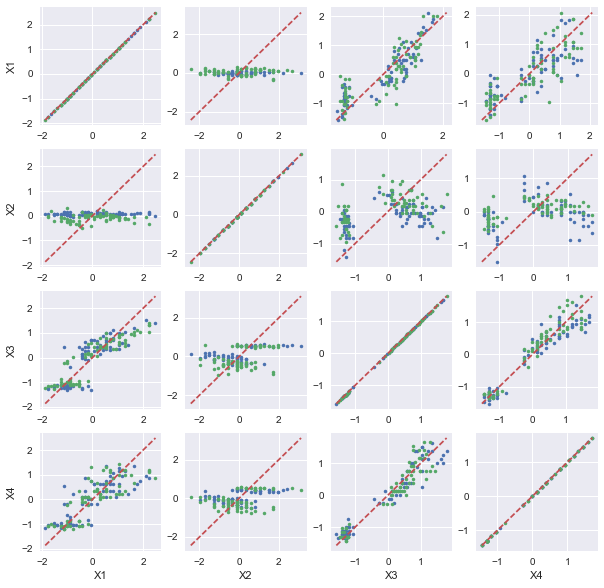

In [ ]:
import matplotlib.pyplot as plt

def pairplot_cross_val(data, model=None, ax=None, **params):
    if ax is None:
        fig, ax = plt.subplots(data.shape[1], data.shape[1], figsize=(10,10))
    if model is None:
        from sklearn.linear_model import LinearRegression
        model = LinearRegression
    
    df = scale(data)    
    for i in range(cor.shape[0]):
        xi = df[:, i:i+1]
        for j in range(cor.shape[1]):
            xj = df[:, j]
            mem = []
            xi_train, xi_test, xj_train, xj_test = train_test_split(xi, xj, train_size=0.5)
            mod = model(**params)            
            mod.fit(xi_train, xj_train)
            v = mod.predict(xi_test)
            mod = model(**params)            
            mod.fit(xi_test, xj_test)
            v2 = mod.predict(xi_train)
            ax[i,j].plot(xj_test, v, ".")
            ax[i,j].plot(xj_train, v2, ".")
            if j == 0:
                ax[i,j].set_ylabel(data.columns[i])
            if i == data.shape[1]-1:
                ax[i,j].set_xlabel(data.columns[j])
            mi = min(min(xj_test), min(v), min(xj_train), min(v2))
            ma = max(max(xj_test), max(v), max(xj_train), max(v2))
            ax[i,j].plot([mi, ma], [mi, ma], "--")
    return ax
            
ax = pairplot_cross_val(df)
ax

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D14D98F438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001D159EFE1D0>]], dtype=object)

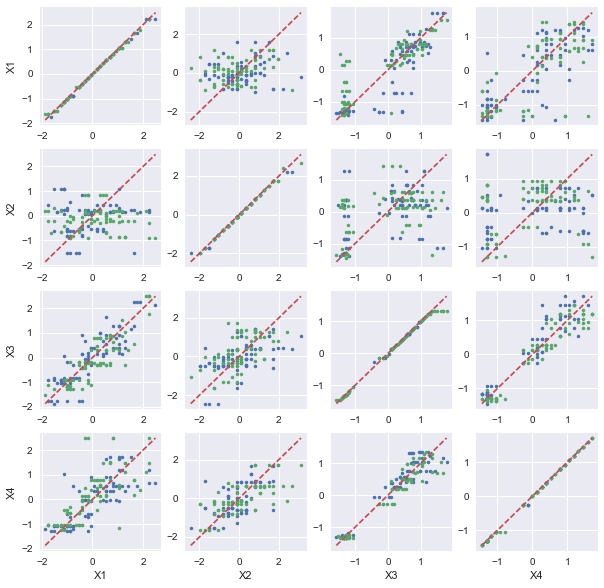

In [ ]:
ax = pairplot_cross_val(df, model=DecisionTreeRegressor)
ax

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D15A2F9828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001D15A64CF98>]], dtype=object)

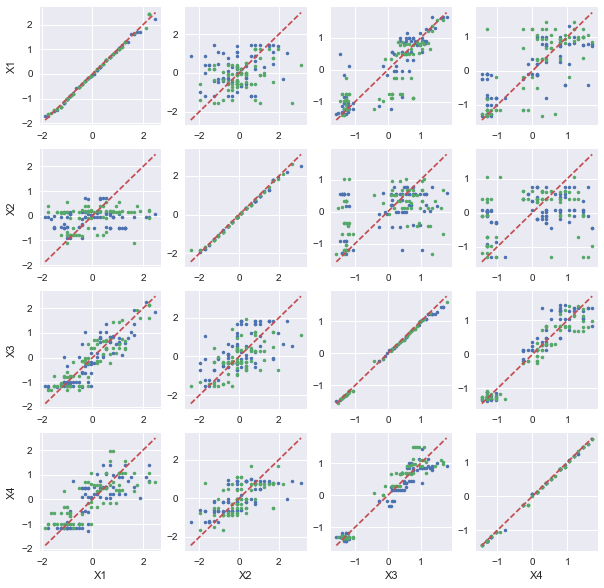

In [ ]:
ax = pairplot_cross_val(df, model=RandomForestRegressor)
ax

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D15A9776D8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001D15AD9B0B8>]], dtype=object)

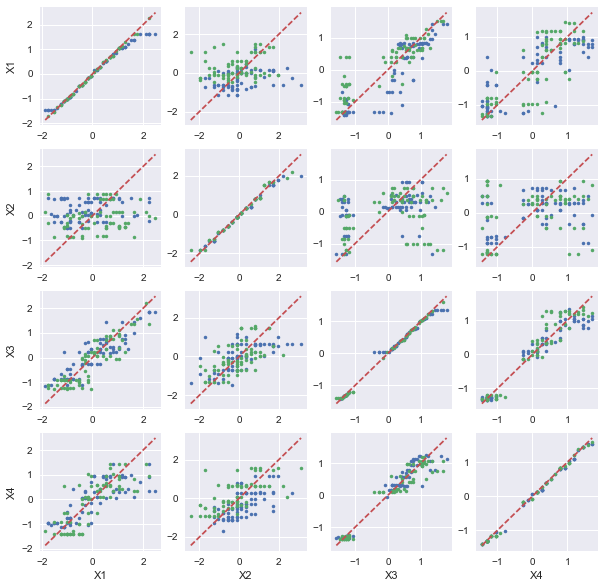

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
ax = pairplot_cross_val(df, model=KNeighborsRegressor)
ax